In [15]:
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf
import cv2
import numpy as np

# projet-sda-deep-learning
#### [GTSRB - German Traffic Sign Recognition Benchmark](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign)

## 1. **Introduction au Projet**
  Le projet consiste en une classification de panneaux de signalisation routière, avec l'objectif de développer un modèle de reconnaissance d'images capable de distinguer différentes classes de panneaux de signalisation.  
  Le projet suit un plan détaillé en 9 étapes, allant de l'introduction au projet et à l'exploration des données, à l'entraînement et à l'évaluation du modèle, en passant par l'amélioration et l'expérimentation, jusqu'à la présentation des résultats.    
  Le projet nécessite l'utilisation de techniques d'apprentissage automatique, notamment les réseaux de neurones convolutionnels (CNN), et l'exploration de différentes méthodes d'augmentation de données, de régularisation et de transfert d'apprentissage.  
  L'objectif final est de développer un modèle capable de classifier correctement les panneaux de signalisation routière avec une grande précision.
 
### Data
*   **Meta** : Le dossier `Meta` contient les métadonnées sur le dataset, telles que le chemin, la forme, la couleur et l'ID de chaque pictogramme.

    - `Path` : access to the file
    - `ClassId` : unique Id of the pictogram within the 43 meta pictograms (class id) 
    - `ShapeId` : contains the color id (0-triangle, 1-circle, 2-diamond, 3-hexagon, 4-inverse triangle)  
    - `ColorId` : contains the shape id (0-red, 1-blue, 2-yellow, 3-white)
    - `SignId` : Sign ID (by Ukrainian Traffic Rules)  

*   **Test** : Le dossier `Test` contient 12630 images uniques pour tester et évaluer le modèle.

    - `Width` : Width of the image
    - `Height` : Height of the image
    - `Roi.X1` : Upper left X coordinate of sign on image
    - `Roi.Y1` : Upper left Y coordinate of sign on image
    - `Roi.X2` : Lower right X coordinate of sign on image
    - `Roi.Y2` : Lower right Y coordinate of sign on image
    - `ClassId` : ClassId of provided image (43 unique image classes)
    - `Path` : Path of the image  

*   **Train** : Le dossier `Train` contient différentes versions augmentées des 43 images de panneaux de signalisation meta.
    
    - `Width` : Width of the image
    - `Height` : Height of the image
    - `Roi.X1` : Upper left X coordinate of sign on image
    - `Roi.Y1` : Upper left Y coordinate of sign on image
    - `Roi.X2` : Lower right X coordinate of sign on image
    - `Roi.Y2` : Lower right Y coordinate of sign on image
    - `ClassId` : ClassId of provided image (43 unique image classes)
    - `Path` : Path of the image  

In [81]:
metabase = pd.read_csv('../input_data/gtsrb-german-traffic-sign/Meta.csv')
display(metabase.head(5))
display(metabase.info())


,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Path     43 non-null     object
 1   ClassId  43 non-null     int64 
 2   ShapeId  43 non-null     int64 
 3   ColorId  43 non-null     int64 
 4   SignId   42 non-null     object
dtypes: int64(3), object(2)
memory usage: 1.8+ KB


None

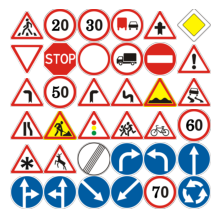

In [82]:
def afficher_images(df, path_column, num_images=6):
   
    paths = df[path_column].tolist()

    fig, axes = plt.subplots(nrows=num_images, ncols=num_images, figsize=(2, 2))
    for i in range(num_images * num_images):
        ax = axes[i // num_images, i % num_images]
        try:
            img = plt.imread(f"../input_data/gtsrb-german-traffic-sign/{paths[i]}")
            ax.imshow(img)
            ax.axis('off')
        except Exception as e:
            ax.text(0.5, 0.5, f"Erreur d'affichage de l'image {i+1}", ha='center', va='center')
            print(f"Erreur d'affichage de l'image {i+1}: {str(e)}")

    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
    plt.show()

afficher_images(metabase, 'Path')

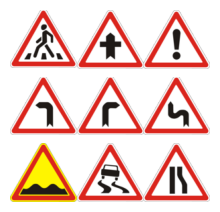

In [74]:
def afficher_images_per_shape(df, num_images=3):
    filtered_df = df[df['ShapeId'] == 0]
    afficher_images(filtered_df, 'Path', num_images)
    
afficher_images_per_shape(metabase)

### Id checked ✅
- ShapeId : 0-triangle, 1-circle, 2-diamond, 3-hexagon, 4-inverse triangle  
- ColorId : 0-red, 1-blue, 2-yellow, 3-white

In [79]:
# Proportion des classes dans le dataset
def afficher_proportions(df):
    shape_proportions = df['ShapeId'].value_counts(normalize=True) * 100
    print("Proportions de ShapeId (%):")
    print(shape_proportions)

    color_proportions = df['ColorId'].value_counts(normalize=True) * 100
    print("\nProportions de ColorId (%):")
    print(color_proportions)


afficher_proportions(metabase)

Proportions de ShapeId (%):
ShapeId
1    58.139535
0    34.883721
2     2.325581
4     2.325581
3     2.325581
Name: proportion, dtype: float64

Proportions de ColorId (%):
ColorId
0    69.767442
1    18.604651
3     9.302326
2     2.325581
Name: proportion, dtype: float64


## 2. **Préparation des Données**
  - Explication des étapes de prétraitement des données.
  - Importance du redimensionnement, de la normalisation et de l’augmentation des données.

## ToDo
- [ ] Chargement et exploration du dataset
  - [ ] Dimensions
  - [ ] Classes
  - [ ] Visualisation des images
  - [ ] Distribution des classes
- [ ] Prétraitement des images
  - [ ] Redimensionnement à une taille fixe (par exemple, 32x32 ou 64x64)
  - [ ] Normalisation des valeurs des pixels (mise à l’échelle entre 0 et 1)
- [ ] Division du dataset en ensembles d’entraînement, de validation et de test
  - [ ] Utilisation de `train_test_split` ou autre technique de séparation
- [ ] Implémentation de l’augmentation des données
  - [ ] Rotation
  - [ ] Zoom
  - [ ] Translation
  - [ ] Variations de luminosité
  - [ ] Via des bibliothèques comme `ImageDataGenerator` ou `torchvision.transforms`


### Répartition des tailles des images :
- Les largeurs d'image sont principalement comprises entre 25 et 61 pixels, représentant environ 79 % des données (9 985 images sur 12 630).  
- Les hauteurs d'image sont également principalement comprises entre 25 et 66 pixels, représentant environ 83 % des données (10 432 images sur 12 630).  
`-->` 64x64 pixels couvre la majorité des images (au moins 80 % des données).

In [86]:
test_df = pd.read_csv('../input_data/gtsrb-german-traffic-sign/Test.csv')

def preprocess_image(image_path, target_size=(32, 32)):
    # Charger l'image
    image = cv2.imread(image_path)
    # Redimensionner l'image
    image = cv2.resize(image, target_size)
    # Convertir l'image en RGB (si elle est en BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Normaliser les valeurs des pixels entre 0 et 1
    image = image / 255.0
    return image


Width mean: 50.50775930324624
Height mean :50.36444972288203
Width med: 43.0
Height med :43.0


Width

Label	Count
25.00 - 37.05	4,552
37.05 - 49.10	3,468
49.10 - 61.15	1,965
61.15 - 73.20	990
73.20 - 85.25	572
85.25 - 97.30	362
97.30 - 109.35	238
109.35 - 121.40	165
121.40 - 133.45	111
133.45 - 145.50	69
145.50 - 157.55	43
157.55 - 169.60	44
169.60 - 181.65	21
181.65 - 193.70	16
193.70 - 205.75	3
205.75 - 217.80	2
217.80 - 229.85	2
229.85 - 241.90	3
241.90 - 253.95	1
253.95 - 266.00	3



## 3. **Conception et Implémentation du Modèle CNN**
  - Présentation des concepts de base des CNN (convolutions, pooling, fully connected layers).
  - Comparaison d’architectures : du simple au complexe (VGG, ResNet).
  - Techniques de régularisation (Dropout, Batch Normalization).

## ToDo
- [ ] Implémentation d’une architecture CNN simple
  - [ ] Couches de convolution
  - [ ] Couches de pooling
  - [ ] Couches fully connected
- [ ] Ajout de techniques de régularisation
  - [ ] Dropout pour prévenir l’overfitting
  - [ ] Batch Normalization pour stabiliser et accélérer l'entraînement
- [ ] Exploration d’architectures plus complexes
  - [ ] Par exemple, VGG16 ou ResNet


## 4. **Entraînement du Modèle**
  - Définir les paramètres d’entraînement (fonction de coût, optimiseur).
  - Importance du suivi des performances sur l’ensemble de validation.

## ToDo
- [ ] Choix de la fonction de coût
  - [ ] `categorical_crossentropy` pour la classification multi-classes
- [ ] Implémentation des optimisateurs
  - [ ] Adam
  - [ ] SGD (avec annealing du taux d’apprentissage)
- [ ] Entraînement du modèle sur les données prétraitées et augmentées
  - [ ] Suivi des performances sur l’ensemble de validation
- [ ] Visualisation des courbes de loss et d’accuracy pendant l’entraînement


## 5. **Évaluation du Modèle**
  - Explication des métriques de performance : précision, rappel, F1-score.
  - Importance de la matrice de confusion pour comprendre les erreurs de classification.

## ToDo
- [ ] Évaluation du modèle sur l’ensemble de test
- [ ] Calcul et affichage des métriques de performance
  - [ ] Précision
  - [ ] Rappel
  - [ ] F1-score
- [ ] Génération et visualisation d’une matrice de confusion
- [ ] Optionnel : comparer les performances des différentes architectures testées

## 6. **Améliorations et Expérimentations**
  - Amélioration des performances (ajustement des hyperparamètres, augmentation des données, transfer learning).
  - Techniques avancées : le transfer learning.

## ToDo 
- [ ] Ajustement des hyperparamètres
  - [ ] Taille des batchs
  - [ ] Taux d’apprentissage
- [ ] Test d’autres techniques d’augmentation des données
- [ ] Implémentation du transfer learning avec un modèle pré-entraîné
  - [ ] Par exemple, ResNet ou VGG pré-entraîné sur ImageNet
- [ ] Fine-tuning du modèle pré-entraîné sur le dataset GTSRB

## 7. **Interprétation et Visualisation des Résultats**
  - Explication de l’importance de visualiser les activations des couches CNN.
  - Présentation de Grad-CAM pour l’interprétation des résultats.

## ToDo
- [ ] Visualisation des activations des différentes couches du modèle
  - [ ] Comprendre comment il extrait les caractéristiques des images
- [ ] Implémentation et visualisation avec Grad-CAM
  - [ ] Voir quelles parties des images sont utilisées par le modèle pour faire ses prédictions
- [ ] Discussion des erreurs courantes
  - [ ] Confusion entre panneaux similaires
  - [ ] Exploration de solutions potentielles

## 8. **Extension du Projet (Facultatif)**
  - Poursuivre le projet (classification + localisation, tests dans des conditions adverses).
  - Propositions pour des expériences plus avancées (détection d’objets, robustesse aux perturbations).

## ToDo
- [ ] Implémentation d’une architecture de détection d’objets
- [ ] Ajout de bruit ou d’occlusions aux images pour tester la robustesse du modèle

## 9. **Code Python, Rédaction du Rapport et Présentation**
  - Résumé du projet.

## ToDo
- [ ] Code Python 
- [ ] Explication détaillée (Rapport 5-10 pages)
- [ ] Explicaiton synthétique (Présentation 10 slides)
- [ ] Sauvegarde du modèle entraîné

## Conclusion